<a href="https://colab.research.google.com/github/tiyu0203/fml/blob/master/FML_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE475 - Frequentist Machine Learning
###  Assignment 2 -- Logistic Regression
### Jonathan Lam, Tiffany Yu, Harris Paspuleti

---
> Implement logistic regression with stochastic gradient descent as the optimization algorithm, with and without the L2 regularization penalty. <br><br> 
Divide your data into roughly 80% train, 10% validation, 10% test as in the previous assignment and use the validation dataset to tune any parameters.




---
## Defining the Models

In [ ]:
# Setting up
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn import preprocessing
import seaborn as sb
from functools import partial

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Base Logistic Classifier
All logistic classifiers subclass from this. This mostly includes the subset initialization (80/10/10 split and optional standardization), since this is common for all of the classifiers.

Each classifier must implement its own `train()` or `validate()` methods.

In [ ]:
# base logistic classifier class; includes some common utilities;
# this class is abstract and doesn't contain a train() or validate() method,
# which must be implemented in its inheritors
class BaseLogisticClassifier:

    # X: NxP ndarray (features)
    # y: Nx1 ndarray (labels)
    # alpha: (maximum) learning rate
    # copySubsetsFrom: treat this as a copy constructor, copy
    # over the subsets from a different BaseLogisticClassifier
    def __init__(self, X, y, alpha=0.01,
                 copySubsetsFrom=None,
                 standardizeFeatures=False):
        self._alpha = alpha
        self._lambda = 0

        # copySubsetsFrom is provided; copy subsplits
        if copySubsetsFrom is not None:
            self._subsets = copySubsetsFrom._subsets.copy()
            P = self._subsets['train']['X'].shape[1] - 1

        # X, y are provided; manually split subsets
        else:
            N, P = X.shape

            # add column of 1's to X
            X = np.hstack((np.ones((N, 1)), X))

            # randomly split data into training, validation, test
            indices = np.arange(N)
            np.random.shuffle(indices)
            split1, split2 = int(N*0.8), int(N*0.9)
            self._subsets = {
                'train': {
                    'X': X[indices[:split1], :],
                    'y': y[indices[:split1], :]
                },
                'validate': {
                    'X': X[indices[split1:split2], :],
                    'y': y[indices[split1:split2], :]
                },
                'test': {
                    'X': X[indices[split2:], :],
                    'y': y[indices[split2:], :]
                }
            }

            # print the lengths of the dataset and each set
            print("Length of dataset:", N)
            print("Length of training:", split1)
            print("Length of validation:", split2-split1)
            print("Length of test:", N-split2)

        # initialize weight vector (includes the bias, hence the P+1)
        self._theta = np.zeros((P+1, 1))

        # intitialize Adam coefficients
        # Adam is an optimization algorithm that can be 
        #used instead of the classical stochastic gradient descent procedure 
        #to update network weights iterative based in training data.
        # adam optimizer
        # beta1. The exponential decay rate for the first moment estimates (e.g. 0.9).
        self._beta1 = 0.9
        # beta2. The exponential decay rate for the second-moment estimates (e.g. 0.999). 
        # This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).
        self._beta2 = 0.999
        # Return an array of zeros with the same shape and type as a given array.
        self._ztheta = np.zeros_like(self._theta)
        self._zthetaSquared = np.zeros_like(self._theta)
        # epsilon. Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).
        self._ep = 0.0001

        # standardize features except for first column of 1's
        if standardizeFeatures:
            for subset in ('train', 'validate', 'test'):
                subsetX = self._subsets[subset]['X']
                # print(subsetX[:,1,np.newaxis])
                self._subsets[subset]['X'] = np.hstack((subsetX[:,1,np.newaxis], preprocessing.StandardScaler().fit(subsetX[:,1:]).transform(subsetX[:,1:])))
            # self._subsets['train']['X'] = preprocessing.StandardScaler().fit(self._subsets['train']['X']).transform(self._subsets['train']['X'])
            # self._subsets['validate']['X'] = preprocessing.StandardScaler().fit(self._subsets['validate']['X']).transform(self._subsets['validate']['X'])
            # self._subsets['test']['X'] = preprocessing.StandardScaler().fit(self._subsets['test']['X']).transform(self._subsets['test']['X'])

            # stan


    def getLogLikelihoods(self):
        return self._loglikelihoods

    def plotLoglikelihood(self):
        iterations = range(0,2000)
        plt.figure()
        plt.plot(iterations, self._loglikelihoods)
        plt.xlabel('Iterations')
        plt.ylabel('Loglikelihoods') 

    def theta(self):
        return self._theta

### Binary Logistic Classifier
This is the unregularized case for the binary logistic classifier. It uses an Adam optimizer in the `step()` function for faster, smoother convergence. (<a href='https://arxiv.org/abs/1412.6980'>Reference for Adam implementation</a>)

Notes on implementation:
- The Adam optimizer is used for better convergence than SGD.
- The functions are all vectorized and the batch size is arbitrary. Right now, `train()` uses the entire training dataset on each iteration (full batch).

In [ ]:
class BinaryLogisticClassifier(BaseLogisticClassifier):

    # hypothesis function (returns yhat); uses trained theta
    # returns N x 1
    def h(self, X):
        return 1 / (1 + np.exp(-X @ self._theta))

    # update function
    # theta_j := theta_j + alpha(y_i -h_theta(x_i)) * x_i_j
    # returns (P+1) x 1
    def grad(self, X, y):
        return X.T @ (y - self.h(X))

    # log likelihood
    def l(self, subset):
        X, y = self._subsets[subset]['X'], self._subsets[subset]['y']
        return y.T @ np.log(self.h(X)) + (1 - y).T @ np.log(1 - self.h(X))

    # percent classified wrong on training subset
    def pctWrong(self, subset='test'):
        X, y = self._subsets[subset]['X'], self._subsets[subset]['y']
        N, _ = X.shape

        # epsilon to prevent prediction of exactly 0.5 to be classified as
        # correct for label being either 0 or 1
        ep = 0.00001

        return np.sum(np.round(np.abs(self.h(X) - y - ep))) / N

    # adam update step
    def step(self, iter, includeMask=None):
        # update adam moments
        thetaGrad = self.grad(self._subsets['train']['X'], self._subsets['train']['y'])
        # weighted average of the gradient
        self._ztheta = self._beta1 * self._ztheta + (1 - self._beta1) * thetaGrad
        # weighted average of the square gradient
        self._zthetaSquared = self._beta2 * self._zthetaSquared + (1 - self._beta2) * thetaGrad ** 2

        # adam bias-corrected moments
        bcZTheta = self._ztheta / (1 - self._beta1 ** (iter + 1))
        bcZThetaSquared = self._zthetaSquared / (1 - self._beta2 ** (iter + 1))

        # adam update rule
        self._theta += self._alpha * bcZTheta / (np.sqrt(bcZThetaSquared) + self._ep)

        # exclude certain features (for stepwise)
        if includeMask is not None:
            self._theta *= includeMask

    def train(self, iterations=2000, includeMask=None):
        # store loglikelihoods for graphing later
        self._loglikelihoods = np.zeros(iterations)
        self._theta = np.zeros((self._subsets['train']['X'].shape[1], 1))

        for i in range(iterations):
            self.step(i, includeMask)
            self._loglikelihoods[i] = self.l(subset='train')

    # baseline sets the bias to the average label, and zeros elsewhere,
    # and calculates the percent wrong on the test dataset
    def baselinePctWrong(self):
        X, y = self._subsets['test']['X'], self._subsets['test']['y']
        N, _ = X.shape
        return np.sum(np.round(np.abs(np.average(self._subsets['train']['y']) - y))) / N

### Stepwise Logistic Classifier
This inherits from the binary logistic classifier, and adds a validate function that follows the algorithm:

- Create a list of the features called `exclude`
- Create an empty list called `include`
- Train the model with no features
- While `exclude` is not empty:
    - Loop through the features of `exclude`:
        - Add the current feature to the model, and calculate the % classified incorrectly
    - Choose the feature that, when added to the existing model, provides the lowest % classification error
    - Add this feature to `include` and to the existing model, and remove it from `exclude`
- We now have P different models, each of which has a different number of features included. Return the model that has the lowest classification error.

In [ ]:
class StepwiseLogisticClassifier(BinaryLogisticClassifier):

    def validate(self):
        _, P = self._subsets['train']['X'].shape
        P -= 1

        # list of features to exclude and include
        exclude = list(range(P))
        include = []
        # list of features to include
        includeMask = np.zeros((P+1, 1)) 
        includeMask[0] = 1

        pctWrongs = np.zeros((P+1, 1))
        #calculate the percent wrong relative to the validate set of data
        pctWrongs[0] = 1 - np.mean(self._subsets['validate']['y'])

        # loops over number of features in model
        for i in range(P):

            # find best next feature to include
            bestPctWrong, bestFeature = float('inf'), None
            for feature in exclude:
                # copy includeMask into currentIncludeMask, unmask feature
                currentIncludeMask = np.array(includeMask)
                currentIncludeMask[feature+1] = 1

                # train on currentIncludeMask
                self.train(includeMask=currentIncludeMask)

                # calculate percent wrong on validation set
                #Trying to find out when it gives you the least error
                pctWrong = self.pctWrong(subset='validate')
                if pctWrong < bestPctWrong:
                    bestPctWrong = pctWrong
                    bestFeature = feature

            # minimize percent wrong
            pctWrongs[i+1] = bestPctWrong

            # add feature to includeMask, remove from exclude
            exclude.remove(bestFeature)
            include.append(bestFeature)
            includeMask[bestFeature] = 1

        # find minimum of pctWrongs
        bestNumFeatures = np.argwhere(pctWrongs == np.min(pctWrongs))[0,0]
        bestIncludeMask = np.zeros((P+1, 1))
        bestIncludeMask[0] = 1
        for i in range(bestNumFeatures):
            bestIncludeMask[include[i]+1] = 1

        # retrain with best include mask, return theta
        self.train(includeMask=bestIncludeMask)
        return self._theta, include[:bestNumFeatures]

### L2 Logistic Classifier
This inherits from the binary logistic classifier, and modifies the gradient to penalize the bias.

The `validate()` method sweeps `lambda` through a logspace.

This also standardizes the features.

In [ ]:
#Class to calculate L2 regularization
class L2LogisticClassifier(BinaryLogisticClassifier):

    # make sure to standardize features
    def __init__(self, X, Y, alpha=0.01, copySubsetsFrom=None):
        super().__init__(X, Y, alpha=alpha,
                         copySubsetsFrom=copySubsetsFrom,
                         standardizeFeatures=True)

    # update function with L2 penalty
    # theta_j := theta_j + alpha(y_i -h_theta(x_i)) * x_i_j
    # returns (P+1)
    # SGD =  j+α(y(i)−hθ(x(i)))x(i)j
    def grad(self, X, y):
        # don't penalize the bias
        return X.T @ (y - self.h(X)) - 2 * self._lambda * np.vstack((np.zeros((1,1)), self._theta[1:,:]))

    def validate(self):
        #create a bunch of lambdas in order to iterate through them
        lams = np.logspace(-20, 5, 100)

        #Removing the ones because we don't want to regularize the bias term
        P = self._subsets['train']['X'].shape[1] - 1
        self._subsets['train']['X'][0,:] = np.ones((1, P+1))
        self._subsets['validate']['X'][0,:] = np.ones((1, P+1))
        self._subsets['test']['X'][0,:] = np.ones((1, P+1))

        bestPctWrong, bestLambda = float('inf'), None
        pctWrongs = np.zeros_like(lams)

        for i, lam in enumerate(lams):
            self._lambda = lam
            self.train()

            pctWrong = self.pctWrong(subset='validate')
            pctWrongs[i] = pctWrong
            # calculate percent wrong on validation set
            #Trying to find out when it gives you the least error
            if pctWrong < bestPctWrong:
                bestPctWrong = pctWrong
                bestLambda = lam

        self._lambda = bestLambda
        self.train()
        return self._theta

### L1 Logistic Classifier

> Stretch goal #1 (3 points): Implement the L1 penalty as well, and produce a Lasso plot like figure 4.13. Include your results in the % correct table. Use the validation dataset to select the optimal lambda and determine the most important features. Do those features agree with the stepwise feature selection?<br><br>
> There are lots of ways to implement the L1 penatly, one possible way is the naive one detailed in this paper:  https://www.aclweb.org/anthology/P09-1054.pdf

This inherits from the binary logistic classifier. It standardizes the features, and applies a L1 penalty using an approximation for the gradient of the L1 penalty loss term as described in the above paper.

In [ ]:
# taken mostly literally from (Tsuruoka et al., 2009); involves an
# estimate of the gradient of the L1 norm (abs function) that involves
# some "memory" for improved performance
class L1LogisticClassifier(BinaryLogisticClassifier):

    # make sure to standardize features
    def __init__(self, X, Y, alpha=0.01, copySubsetsFrom=None):
        super().__init__(X, Y, alpha=alpha,
                         copySubsetsFrom=copySubsetsFrom,
                         standardizeFeatures=True)

    # apply this after Adam update rule (would be difficult to incorporate with Adam)
    def applyL1Penalty(self):
        for i, theta_i in enumerate(self._theta.reshape(-1)):
            # start from 1 to not penalize the bias
            if i == 0:
                continue

            z = theta_i
            if theta_i > 0:
                self._theta[i,0] = max(0., theta_i - (self._u + self._q[i]))
            elif theta_i < 0:
                self._theta[i,0] = min(0., theta_i + (self._u + self._q[i]))
            self._q[i] += theta_i - z

    # log likelihood
    def l(self, subset):
        X, y = self._subsets[subset]['X'], self._subsets[subset]['y']
        return y.T @ np.log(self.h(X)) + (1 - y).T @ np.log(1 - self.h(X))

    def train(self, iterations):
        self._theta *= 0.
        self._u = 0.
        self._q = self._theta.copy().reshape(-1)
        self._N = self._subsets['train']['X'].shape[0]

        # loglikelihoods are for graphing later
        self._loglikelihoods = np.zeros(iterations)

        for i in range(iterations):
            self._u += self._alpha * self._C / self._N
            self.step(i)
            self.applyL1Penalty()
            self._loglikelihoods[i] = self.l(subset='train')

    def validate(self, iterations=2000):
        # just to be sure; undo l2 regularization
        self._lambda = 0.

        # l1 regularization parameter; C is the letter used in the text
        cIteration = np.logspace(-8, 0, 30)
        bestPctWrong, bestC = float('inf'), None
        pctWrongs = np.zeros_like(cIteration)

        # note: coefficients includes bias
        coefficients = np.zeros((cIteration.size, self._theta.size))

        for j, c in enumerate(cIteration):
            self._C = c
            self.train(iterations)

            coefficients[j,:] = self._theta.reshape(-1)
            pctWrong = self.pctWrong(subset='validate')
            pctWrongs[j] = pctWrong
            if pctWrong < bestPctWrong:
                bestPctWrong = pctWrong
                bestC = c

                # save these so we don't have to retrain on best later
                bestLogLikelihoods = self._loglikelihoods.copy()
                bestTheta = self._theta.copy()
                
        self._C = bestC
        self._loglikelihoods = bestLogLikelihoods
        self._theta = bestTheta

        return self._C, coefficients

### Multinomial (Trinary) Logistic Regression

> Stretch goal #2 (3 points): Extend your unregularized logistic regression to mutlinomial regression(i.e. more than binary classification). It is a pretty straightforward extension, but its not covered in elements of stats. You can google for derivations if you want, but mainly all you really need is to find the gradient of the loss function in the multinomial case. This is covered in section 4.3.4 of another classic ML text by Bishop(bootleg pdf here: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf). The equation for the gradient is eqn 4.109. Test your approach on a simple M-ary classification dataset like the Iris dataset from UCI.

For lack of time, this implementation is hardcoded for a $K=3$ problem (trinary), but it still incorporates the same concepts as any multinomial problem.

The dataset feature matrix shape should be the same, but the dataset labels should be a one-hot encoded matrix (i.e., $N\times K$).

Most of the functions are rewritten, since the binary classification equivalents are no longer sufficient. The Adam optimizer is replaced with a simpler gradient descent update rule.

In [ ]:
# multinomial case, hardcoded for K=3; uses simple SGA rather than Adam
class TrinaryLogisticClassifier(BaseLogisticClassifier):

    # returns NxK matrix, where each row is the predicted probabilities
    # of each of the K classes
    def h(self, X):
        a1 = np.exp(X @ self._theta1)
        a2 = np.exp(X @ self._theta2)
        return np.hstack((a1/(1+a1+a2), a2/(1+a1+a2), 1/(1+a1+a2)))

    # returns (gradTheta1, gradTheta2)
    def grad(self):
        X, y = self._subsets['train']['X'], self._subsets['train']['y']
        P = X.shape[1] - 1
        
        # eq. 4.109 (p. 209) of "Pattern Recognition and Machine Learning"
        # but a little vectorized
        grads = np.zeros((P+1, 2))
        for j in range(2):
            grads[:,j] = X.T @ (y[:,j] - self.h(X)[:,j])
        return grads

    # calculate percent wrong: compares argmax of estimate and label
    def pctWrong(self, subset='test'):
        X, y = self._subsets[subset]['X'], self._subsets[subset]['y']
        N = X.shape[0]
        return np.sum(np.round(np.abs(np.argmax(self.h(X), axis=1) - \
            np.argmax(y, axis=1)))) / N

    # hardcoded 3-class classifier (e.g., for UCI Iris dataset)
    def trinaryClassificationTrain(self, iterations=2000):
        N, P = self._subsets['train']['X'].shape
        P -= 1

        # do the binary classification problem K-1 times
        self._theta1 = np.zeros((P+1, 1))
        self._theta2 = np.zeros((P+1, 1))

        for i in range(iterations):
            # use basic sgd (not adam)
            grads = self.grad()
            self._theta1 += self._alpha * grads[:,0][:,np.newaxis]
            self._theta2 += self._alpha * grads[:,1][:,np.newaxis]

        return self._theta1, self._theta2

---
## Running the Models

### Binary Classification of the SAHD Dataset

> Replicate the analysis of the South African heart disease dataset from the Elements of Statistical Learning textbook and plot figure 4.12. Additionally, report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table. Instead of plotting the tables and dropping terms based on Z score, select the optimal model using forward stepwise via cross-validation and report which features are the most important.

Length of dataset: 462
Length of training: 369
Length of validation: 46
Length of test: 47
theta: [[-3.97227696e+00]
 [ 2.62565496e-03]
 [ 6.69992005e-02]
 [ 1.82021868e-01]
 [ 8.19843244e-01]
 [-3.19375348e-02]
 [ 2.45009621e-03]
 [ 4.91780240e-02]]
% classified correct for unregularized: 72.0%


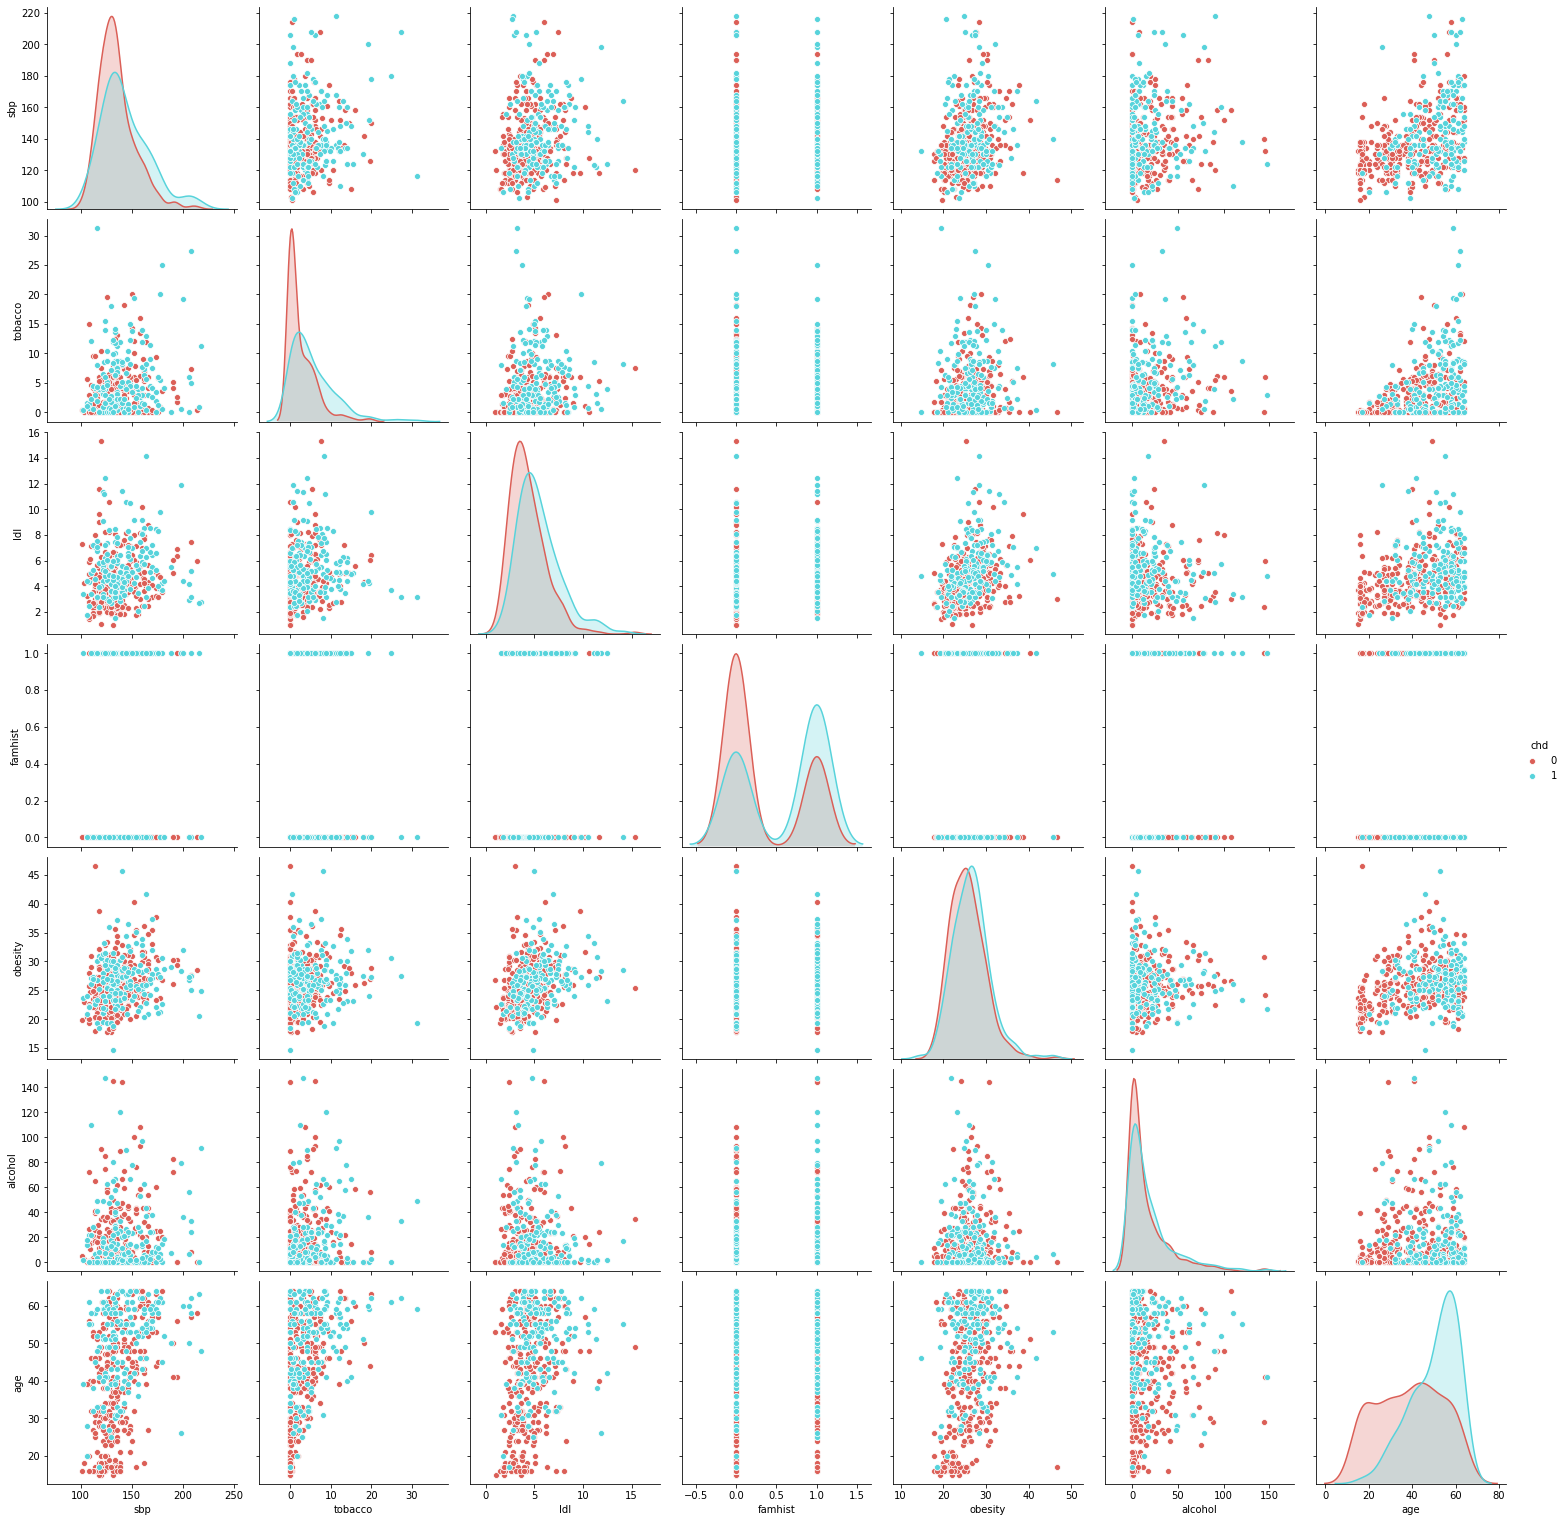

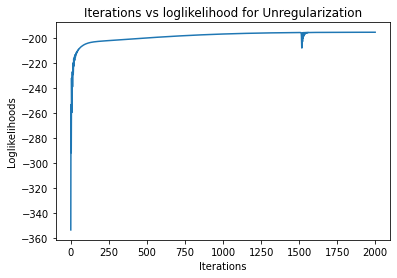

In [ ]:
# Import the South African heart disease dataset (in Google Colab)
# Read through data and create dataset
sahdDataset = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data', index_col=0)

# Textbook drops adiposity and typea
sahdDataset = sahdDataset.drop(['adiposity', 'typea'], axis=1)

# Turn famhist into a quantitative variable
sahdDataset['famhist'] = (sahdDataset['famhist'] == 'Present')*1

# Creates a graph like figure 4.12
sb.pairplot(sahdDataset, hue = 'chd',palette="hls", height = 3)

# list the features
term = list(sahdDataset.columns.values[:-1])

# Generate Features matrix : NxP
sahdDatasetX = sahdDataset.drop(['chd'], axis=1).to_numpy()
# Generate Label matrix : Nx1
sahdDatasety = sahdDataset.loc[:, 'chd'].to_numpy().reshape(-1, 1)

# PART 1: RECREATE TABLE 4.
binaryClassifier = BinaryLogisticClassifier(sahdDatasetX, sahdDatasety)
binaryClassifier.train()
binaryClassifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for Unregularization')
correct_unregularized = np.around((1 - binaryClassifier.pctWrong()) * 100)
print(f'theta: {binaryClassifier.theta()}\n% classified correct for unregularized: {np.around((1 - binaryClassifier.pctWrong()) * 100)}%')
correct_baseline = np.around((1. - binaryClassifier.baselinePctWrong()) * 100)

theta: [[-1.11244286]
 [ 0.        ]
 [ 0.13245139]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
% classified correct for stepwise: 70.0%
The most important features(s) in order:  ['tobacco']


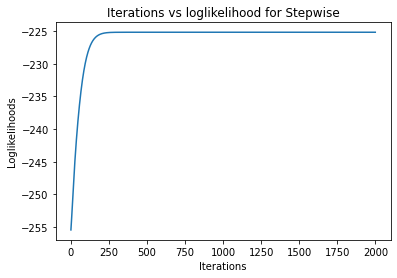

In [ ]:
# PART 2: STEPWISE
stepwiseClassifier = StepwiseLogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
_, optimalFeatures = stepwiseClassifier.validate()
stepwiseClassifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for Stepwise')

correct_stepwise = np.around((1 - stepwiseClassifier.pctWrong()) * 100)
print(f'theta: {stepwiseClassifier.theta()}\n% classified correct for stepwise: {np.around((1 - stepwiseClassifier.pctWrong()) * 100)}%')

#report which features are the most important
print('The most important features(s) in order: ', [term[optimalFeature] for optimalFeature in optimalFeatures])

theta: [[-0.0042613 ]
 [ 0.10590091]
 [ 0.13889517]
 [ 0.13383285]
 [ 0.13248296]
 [ 0.03336894]
 [ 0.02454988]
 [ 0.20732039]]
% classified correct for L2 regularized: 77.0%


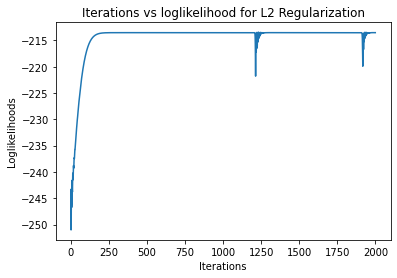

In [ ]:
#PART 3: L2 REGULARIZATION
l2Classifier = L2LogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
l2Classifier.validate()
l2Classifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for L2 Regularization')

correct_L2regularized = np.around((1 - l2Classifier.pctWrong()) * 100)
print(f'theta: {l2Classifier.theta()}\n% classified correct for L2 regularized: {np.around((1 - l2Classifier.pctWrong()) * 100)}%')

theta: [[0.16911823]
 [0.        ]
 [0.23362606]
 [0.23488502]
 [0.24982351]
 [0.        ]
 [0.01322457]
 [0.32304502]]
% classified correct for L1 regularized: 79.0%


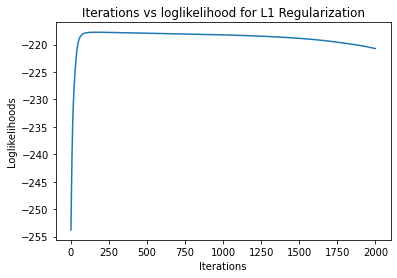

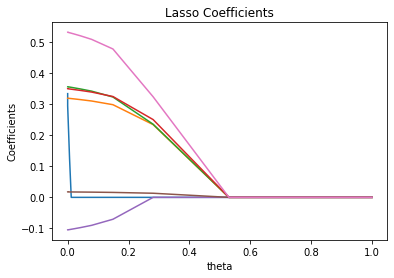

In [ ]:
# STRETCH GOAL 1: L1 REGULARIZATION
l1Classifier = L1LogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
bestC, coefficients = l1Classifier.validate()
l1Classifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for L1 Regularization')

cIterations = np.logspace(-8, 0, 30)
plt.figure()
plt.plot(cIterations, coefficients[:,1:])
plt.xlabel('theta')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients')
correct_L1regularized = np.around((1 - l1Classifier.pctWrong()) * 100)
print(f'theta: {l1Classifier.theta()}\n% classified correct for L1 regularized: {np.around((1 - l1Classifier.pctWrong()) * 100)}%')

> Additionally, report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table. 

In [ ]:
correct = list([[correct_baseline, correct_unregularized, correct_stepwise, correct_L2regularized, correct_L1regularized]])
models = list(['Baseline', 'Unregularized', 'Stepwise', 'L2 regularization', 'L1 regularization'])

table = tabulate(correct, headers=models,tablefmt='pretty')
print('Table 1: % Correct for all the Models')
print(table)

Table 1: % Correct for all the Models
+----------+---------------+----------+-------------------+-------------------+
| Baseline | Unregularized | Stepwise | L2 regularization | L1 regularization |
+----------+---------------+----------+-------------------+-------------------+
|   60.0   |     72.0      |   70.0   |       77.0        |       79.0        |
+----------+---------------+----------+-------------------+-------------------+


Notes on most important feastures chosen:

- The most important features to include fluctuates each time the logistic regresion classifier is run
- Although it fluctuates, there are a few terms that always seem to be the top such as tobacco, famhist, sbh (systolic blood pressure), and age
- The features that were indictated makes sense because tobacco is known to cause heart failure, especially those who had smoked in the past
- Family history also is an indicator if a person might have health issues in the future because some health problems are due to genetics
- The older you get, the more likely you might have heart failure

Other notes: 
- The unregularized and stepwise model gave the highest accuracy for almost all of the times the data was classified
- Unregularized usually gave the highest accuracy
- L2 regularization is usually used to prevent overfitting; however, since this dataset was not that large, overfitting wasn't an issue which meant l2 regularization wasn't necessary
- L1 regularization gives and extremely high accuracy, which would make it the most optimal model
- Looking at the lasso plot, the features that are the most important would be tobacco, famhist, age, ldl
- The features from the lasso plot agree with the features from the stepwise

### Binary Classification of the Breast Cancer Dataset

> Repeat this analysis for a binary classification dataset of your choice from UCI or another repository.

From the dataset description:

>  Attribute........................Domain                     
  1. Sample code number            id number                                  
  2. Clump Thickness               1 - 10                                     
  3. Uniformity of Cell Size       1 - 10                                     
  4. Uniformity of Cell Shape      1 - 10                                     
  5. Marginal Adhesion             1 - 10                                     
  6. Single Epithelial Cell Size   1 - 10                                     
  7. Bare Nuclei                   1 - 10                                     
  8. Bland Chromatin               1 - 10                                     
  9. Normal Nucleoli               1 - 10                                     
  10. Mitoses                       1 - 10                                     
  11. Class:                        (2 for benign, 4 for malignant)

Length of dataset: 683
Length of training: 546
Length of validation: 68
Length of test: 69
theta: [[-7.38720214]
 [ 0.26532443]
 [ 0.13456965]
 [ 0.40163983]
 [ 0.18669206]
 [ 0.02447402]
 [ 0.28032114]
 [ 0.36474628]
 [ 0.1738657 ]
 [ 0.1841025 ]]
% classified correct for unregularized: 93.0%


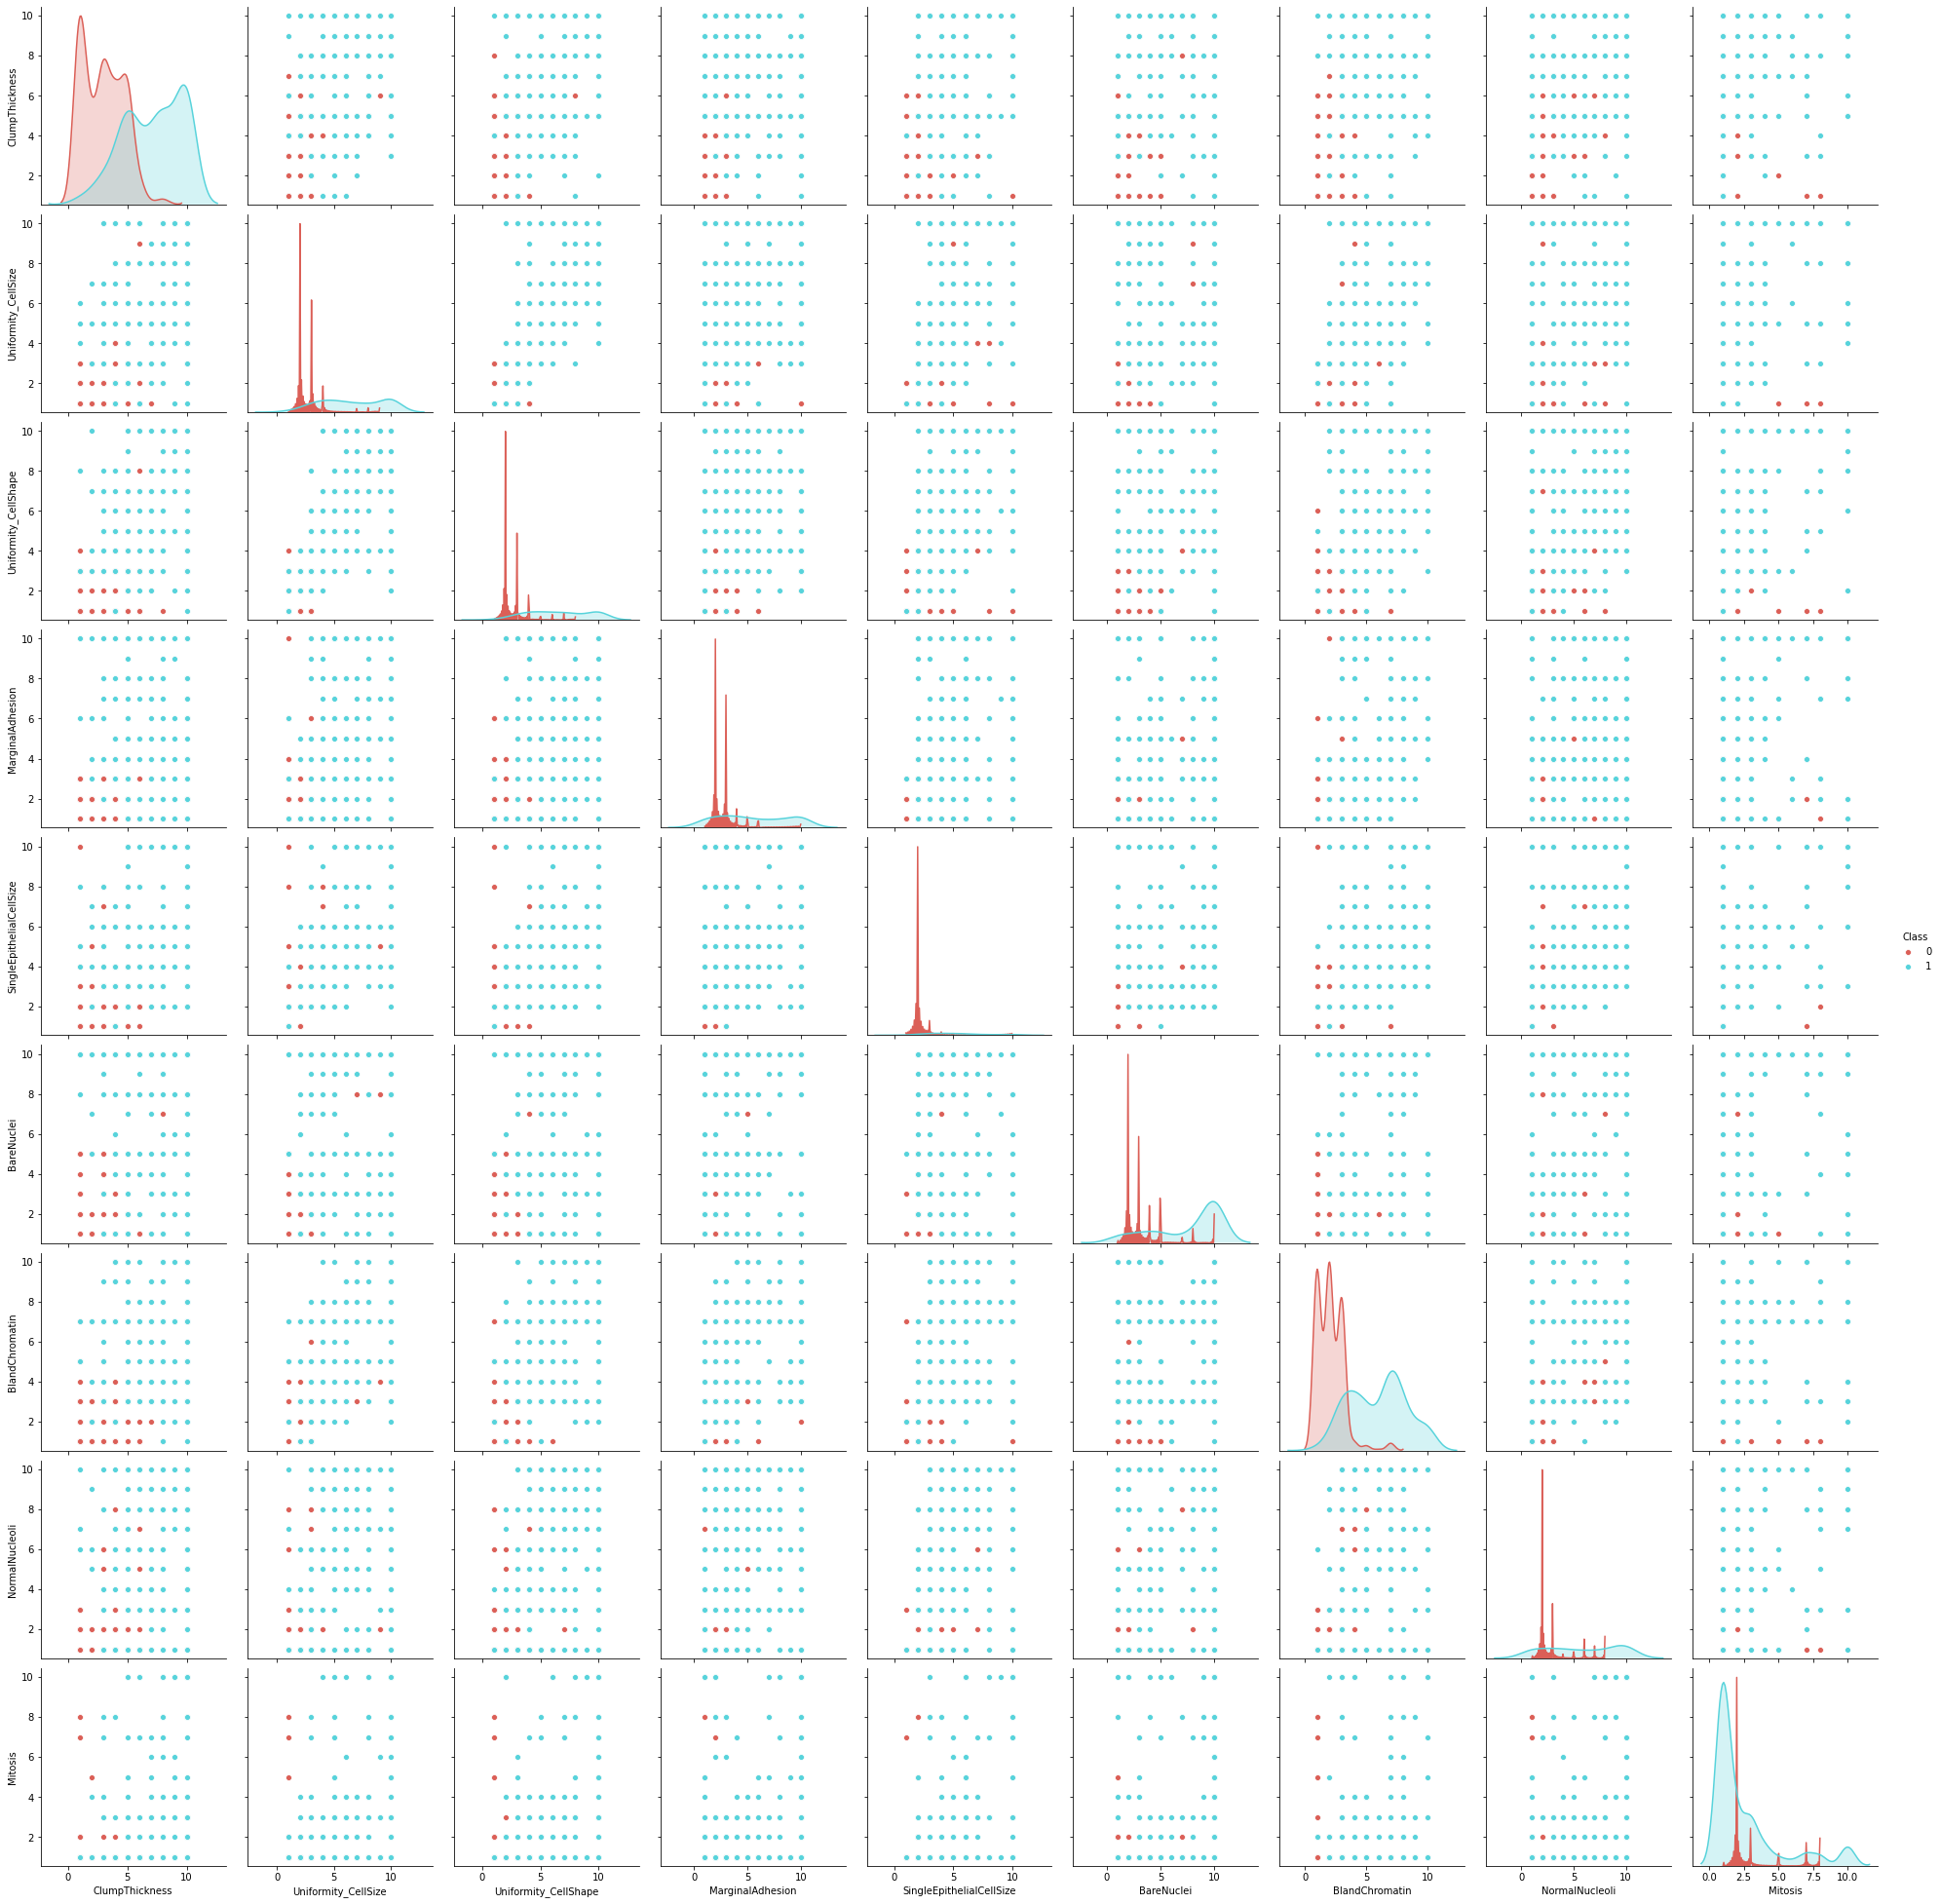

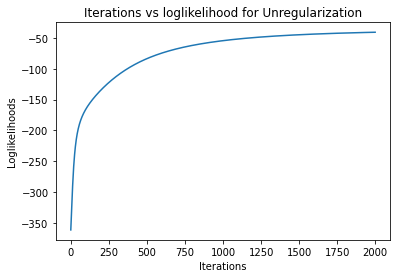

In [ ]:
# Dataset Description: http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names 
# Read through data and create dataset
bcDataset = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', names=["ID", "ClumpThickness", "Uniformity_CellSize", "Uniformity_CellShape", "MarginalAdhesion",
                             "SingleEpithelialCellSize", "BareNuclei", "BlandChromatin", "NormalNucleoli", 
                             "Mitosis", "Class"])
bcDataset.pop('ID')

# There are ? for missing data, so we drop the rows that have them 
bcDataset = bcDataset.apply(partial(pd.to_numeric, errors='coerce'))
bcDataset = bcDataset.dropna(axis = 0)

# Change labels to have 0 for benign and 1 for malignant
bcDataset['Class'] = (bcDataset['Class'] == 4)*1

# Creates a graph like figure 4.12
sb.pairplot(bcDataset, hue = 'Class',palette="hls", height = 3)

# list the features
term = list(bcDataset.columns.values[:-1])

# Generate Features matrix : NxP
bcDatasetX = bcDataset.drop(['Class'], axis=1).to_numpy()
# Generate Label matrix : Nx1
bcDatasety = bcDataset.loc[:, 'Class'].to_numpy().reshape(-1, 1)

# PART 1: RECREATE TABLE 4.
binaryClassifier = BinaryLogisticClassifier(bcDatasetX, bcDatasety)
binaryClassifier.train()
binaryClassifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for Unregularization')
correct_unregularized = np.around((1 - binaryClassifier.pctWrong()) * 100)
print(f'theta: {binaryClassifier.theta()}\n% classified correct for unregularized: {np.around((1 - binaryClassifier.pctWrong()) * 100)}%')
correct_baseline = np.around((1 - binaryClassifier.baselinePctWrong()) * 100)

theta: [[-5.92093473]
 [ 0.        ]
 [ 1.19591208]
 [ 0.        ]
 [ 0.        ]
 [ 0.28331059]
 [ 0.        ]
 [ 0.        ]
 [ 0.37411502]
 [ 0.        ]]
% classified correct for stepwise: 91.0%
The most important features(s) in order:  ['SingleEpithelialCellSize', 'Uniformity_CellSize', 'NormalNucleoli']


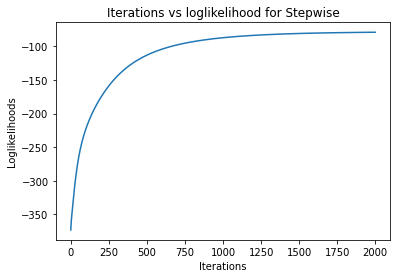

In [ ]:
# PART 2: STEPWISE
stepwiseClassifier = StepwiseLogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
_, optimalFeatures = stepwiseClassifier.validate()
stepwiseClassifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for Stepwise')

correct_stepwise = np.around((1 - stepwiseClassifier.pctWrong()) * 100)
print(f'theta: {stepwiseClassifier.theta()}\n% classified correct for stepwise: {np.around((1 - stepwiseClassifier.pctWrong()) * 100)}%')

#report which features are the most important
print('The most important features(s) in order: ', [term[optimalFeature] for optimalFeature in optimalFeatures])

theta: [[0.01741748]
 [0.04328471]
 [0.04999025]
 [0.05081505]
 [0.0437788 ]
 [0.04164145]
 [0.05106646]
 [0.04696949]
 [0.04385446]
 [0.0249921 ]]
% classified correct for L2 regularized: 93.0%


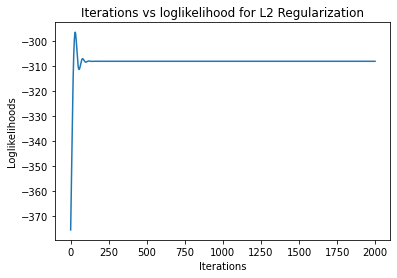

In [ ]:
#PART 3: L2 REGULARIZATION
l2Classifier = L2LogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
l2Classifier.validate()
l2Classifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for L2 Regularization')

correct_L2regularized = np.around((1 - l2Classifier.pctWrong()) * 100)
print(f'theta: {l2Classifier.theta()}\n% classified correct for L2 regularized: {np.around((1 - l2Classifier.pctWrong()) * 100)}%')

theta: [[1.21049955]
 [0.        ]
 [0.48962964]
 [0.73918101]
 [0.62710808]
 [0.08504367]
 [0.84160619]
 [0.96372163]
 [0.41017053]
 [0.80232168]]
% classified correct for L1 regularized: 93.0%


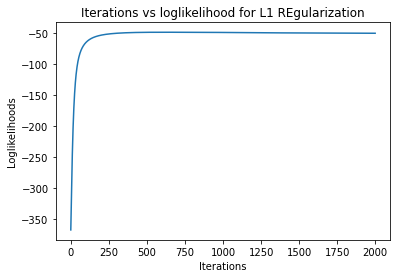

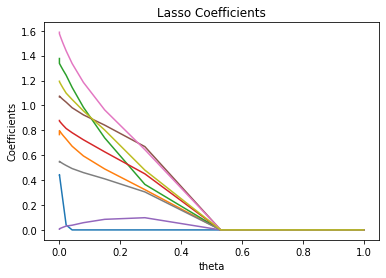

In [ ]:
# STRETCH GOAL 1: L1 REGULARIZATION
l1Classifier = L1LogisticClassifier(None, None, copySubsetsFrom=binaryClassifier)
bestC, coefficients = l1Classifier.validate()
l1Classifier.plotLoglikelihood()
plt.title('Iterations vs loglikelihood for L1 REgularization')

cIterations = np.logspace(-8, 0, 30)
plt.figure()
plt.plot(cIterations, coefficients[:,1:])
plt.xlabel('theta')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients')
correct_L1regularized = np.around((1 - l1Classifier.pctWrong()) * 100)
print(f'theta: {l1Classifier.theta()}\n% classified correct for L1 regularized: {np.around((1 - l1Classifier.pctWrong()) * 100)}%')

> Additionally, report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table.

In [ ]:
correct = list([[correct_baseline, correct_unregularized, correct_stepwise, correct_L2regularized, correct_L1regularized]])
models = list(['Baseline', 'Unregularized', 'Stepwise', 'L2 regularization', 'L1 regularization'])

table = tabulate(correct, headers=models,tablefmt='pretty')
print('Table 1: % Correct for all the Models')
print(table)

Table 1: % Correct for all the Models
+----------+---------------+----------+-------------------+-------------------+
| Baseline | Unregularized | Stepwise | L2 regularization | L1 regularization |
+----------+---------------+----------+-------------------+-------------------+
|   65.0   |     93.0      |   91.0   |       93.0        |       93.0        |
+----------+---------------+----------+-------------------+-------------------+


Notes on selected features:
- The feature that was chosen most was Uniformity Cell size. ALmost all of the times the data was processed, this feature was chose
- For breast cancer, the growth of cells is usually the biggest indicator if the person has cancer or not (spreading of the diseased cells within their body and could be seen in a form of a tumor)
- Marginal Adhesion also was chosen as one of the most important features; however, this occurred very rarely

Other notes:
- Both unregularized and l2 regularization produced about the same amount of accuracy
- These two models gave the highest accuracy, but just from looking at the accuracy, we cannot chose which model is the most optimal
- Stepwise model is the least optimal 
- L1 regularization gives us the highest accuracy, which would make it the most optimal model
- Looking at the lasso plot, the most important features are Mitosis, Bland Chromatin, Bare Nuclei
- The features from the lasso plot don't match with the stepwise 

### Multinomial Classification of the Iris dataset
Features include sepal length and width, petal length and width, and the target is one of three types of iris flowers.

The classification works very well, typically classifying around 98% correct on the training subset and ~100% correct on the test subset, which indicates that the dataset is highly linearly-separable.

In [ ]:
# iris dataset for multiclass (3-class regression)
irisDataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

# one-hot encode labels
irisDatasety = np.vstack((
    (irisDataset.iloc[:,4] == 'Iris-setosa').to_numpy(dtype=np.float32),
    (irisDataset.iloc[:,4] == 'Iris-versicolor').to_numpy(dtype=np.float32),
    (irisDataset.iloc[:,4] == 'Iris-virginica').to_numpy(dtype=np.float32))).T

# feature matrix
irisDatasetX = irisDataset.iloc[:,:4].to_numpy()

irisClassifier = TrinaryLogisticClassifier(irisDatasetX, irisDatasety)
irisClassifier.trinaryClassificationTrain()
print(f'% correct on iris dataset: {(1 - irisClassifier.pctWrong())*100}')
pd.DataFrame(data=np.hstack((irisClassifier._theta1, irisClassifier._theta2)),
             columns=['theta_1', 'theta_2'],
             index=['bias', 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])

Length of dataset: 149
Length of training: 119
Length of validation: 15
Length of test: 15
% correct on iris dataset: 100.0


,theta_1,theta_2
bias,2.726092,6.315390
sepal length (cm),6.251550,6.358187
sepal width (cm),11.632527,5.278686
petal length (cm),-15.197718,-9.101620
petal width (cm),-7.129879,-9.910898


In [ ]:
print('Comparison of prediction to actual labels')
pd.DataFrame(data=np.hstack((np.around(irisClassifier.h(irisClassifier._subsets['test']['X']), 1), irisClassifier._subsets['test']['y'])),
             columns=['PC1', 'PC2', 'PC3', 'AC1', 'AC2', 'AC3'])

Comparison of prediction to actual labels


,PC1,PC2,PC3,AC1,AC2,AC3
0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0
9,1.0,0.0,0.0,1.0,0.0,0.0


Here, "PC1" means "predicted class 1", "AC1" means "actual class 1". The predictions match the actual labels very well.